# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [1]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [3]:
client = MongoClient(mongod_connect)
db = client.gp28 # use or create a database named demo
tweet_collection = db.finalproject #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [5]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [6]:
count = 100 #number of returned tweets, default and max is 100
geocode = "35.843965,-78.7851414,100mi"  # define the location
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [7]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Fri Dec 18 02:01:06 +0000 2020'
'Fri Dec 18 01:56:38 +0000 2020'
'Fri Dec 18 01:51:17 +0000 2020'
'Fri Dec 18 01:49:17 +0000 2020'
'Fri Dec 18 01:48:40 +0000 2020'
'Fri Dec 18 01:43:30 +0000 2020'
'Fri Dec 18 01:43:19 +0000 2020'
'Fri Dec 18 01:41:00 +0000 2020'
'Fri Dec 18 01:39:29 +0000 2020'
'Fri Dec 18 01:39:12 +0000 2020'
'Fri Dec 18 01:39:10 +0000 2020'
'Fri Dec 18 01:37:36 +0000 2020'
'Fri Dec 18 01:35:06 +0000 2020'
'Fri Dec 18 01:26:49 +0000 2020'
'Fri Dec 18 01:23:06 +0000 2020'
'Fri Dec 18 01:22:21 +0000 2020'
'Fri Dec 18 01:22:10 +0000 2020'
'Fri Dec 18 01:19:00 +0000 2020'
'Fri Dec 18 01:18:55 +0000 2020'
'Fri Dec 18 01:18:07 +0000 2020'
'Fri Dec 18 01:14:59 +0000 2020'
'Fri Dec 18 01:14:53 +0000 2020'
'Fri Dec 18 01:13:58 +0000 2020'
'Fri Dec 18 01:11:26 +0000 2020'
'Fri Dec 18 01:09:33 +0000 2020'
'Fri Dec 18 01:08:52 +0000 2020'
'Fri Dec 18 01:04:54 +0000 2020'
'Fri Dec 18 01:03:59 +0000 2020'
'Fri Dec 18 01:03:50 +0000 2020'
'Fri Dec 18 00:57:27 +0000 2020'
'Fri Dec 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [8]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Dec 17 13:03:12 +0000 2020'


KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [9]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

7763
4935


Create a text index and print the Tweets containing specific keywords. 

In [10]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [11]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [12]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: John H Myers
text: What about peoples that had covid19, should they take the vaccine if approve? #covid19
----
name: David Abbott
text: #covid19
----
name: Paul Simpson ✝️ 🇺🇸🇮🇱
text: @washingtonpost Fact:  Every death attributed to Covid19, was not due to Covid19.
----
name: Darlene S.
text: @Acosta Why, @VP doesn't do anything about #COVID19 for the people of the US! He doesn't believe in #COVID19 , so why get a vaccine??
----
name: Why You Lie?
text: #ItsSafeToBet, the CoVID19 vaccine isn't going to work, and CoVID19 isn't going away. https://t.co/V4XCjNHRA1
----
name: Shannon Holley
text: This is why we can’t get past COVID19. #WearYourMask #StopTheSpread #COVIDー19 https://t.co/AMP2ekIj4Y
----
name: Atheist Black Chic
text: What should be done now to prevent the spread of Covid19 in black communities and the death of black people from Covid19 in America?
----
name: Kate
text: Someone help rex 🥺 #COVID19 #coronavirus #converse #COVID19 #COVId https://t.co/wCJeyRXgod
----
n

In [13]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [14]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,extended_entities,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,retweeted_status
0,5fdbe05ce1a3dbb526ee2422,Thu Dec 10 20:33:15 +0000 2020,1337133297147719688,1337133297147719688,"What about peoples that had covid19, should th...",False,"{'hashtags': [{'text': 'covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,5fdbe042e1a3dbb526ee1a69,Mon Dec 14 05:10:44 +0000 2020,1338350688607342592,1338350688607342592,#covid19,False,"{'hashtags': [{'text': 'covid19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",1.338350e+18,...,3,False,False,und,NaN,NaN,NaN,NaN,NaN,NaN
2,5fdbe02be1a3dbb526ee11a4,Wed Dec 16 18:22:08 +0000 2020,1339274628750061568,1339274628750061568,@washingtonpost Fact: Every death attributed ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.339262e+18,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
3,5fdbe027e1a3dbb526ee1046,Thu Dec 17 00:05:15 +0000 2020,1339360975150063619,1339360975150063619,"@Acosta Why, @VP doesn't do anything about #CO...",False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.339357e+18,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
4,5fdbe06fe1a3dbb526ee2aae,Wed Dec 09 03:19:20 +0000 2020,1336510714706587653,1336510714706587653,"#ItsSafeToBet, the CoVID19 vaccine isn't going...",False,"{'hashtags': [{'text': 'ItsSafeToBet', 'indice...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,"{'media': [{'id': 1336510708096380928, 'id_str...",False,NaN,NaN,NaN,NaN
5,5fdbe046e1a3dbb526ee1c17,Sat Dec 12 23:19:06 +0000 2020,1337899812629450752,1337899812629450752,This is why we can’t get past COVID19. #WearYo...,False,"{'hashtags': [{'text': 'WearYourMask', 'indice...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1,False,False,en,NaN,False,1.337863e+18,1337862695639453705,{'created_at': 'Sat Dec 12 20:51:37 +0000 2020...,NaN
6,5fdbe033e1a3dbb526ee14b9,Tue Dec 15 20:42:11 +0000 2020,1338947483293130755,1338947483293130755,What should be done now to prevent the spread ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,29,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
7,5fdbe051e1a3dbb526ee2044,Fri Dec 11 06:28:15 +0000 2020,1337283035792805889,1337283035792805889,Someone help rex 🥺 #COVID19 #coronavirus #conv...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,"{'media': [{'id': 1337283032093483008, 'id_str...",False,NaN,NaN,NaN,NaN
8,5fdbe03fe1a3dbb526ee1934,Mon Dec 14 16:36:01 +0000 2020,1338523145888784385,1338523145888784385,"RT @Billy_K_Ball: It's a cliche, but this is w...",False,"{'hashtags': [{'text': 'ncpol', 'indices': [10...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,...,0,False,False,en,NaN,NaN,1.338496e+18,1338495977192382467,NaN,{'created_at': 'Mon Dec 14 16:02:57 +0000 2020...
9,5fdbe03de1a3dbb526ee18ac,Mon Dec 14 18:08:01 +0000 2020,1338546299273170951,1338546299273170951,"RT @Billy_K_Ball: It's a cliche, but this is w...",False,"{'hashtags': [{'text': 'ncpol', 'indices': [10...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""htt

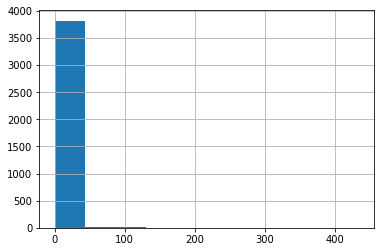

In [15]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count